In [1]:
# Ignore SQLITE warnings related to Decimal numbers
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print (c['name'],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print (c['name'],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#Calculation of start and end date
dt_string = session.query(func.max(Measurement.date)).group_by(Measurement.station).\
       order_by(func.max(Measurement.date).desc()).limit(1).all()[0][0]

end_date = dt.datetime.strptime(dt_string, '%Y-%m-%d').date()

start_date = end_date - dt.timedelta(days=365)

print(end_date)
print(start_date)

2017-08-23
2016-08-23


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

data_points = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).\
    order_by(Measurement.date)

dataplot_data=pd.DataFrame(data_points)
dataplot_data.set_index('date', inplace=True)
dataplot_data=dataplot_data.dropna()

dataplot_data.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


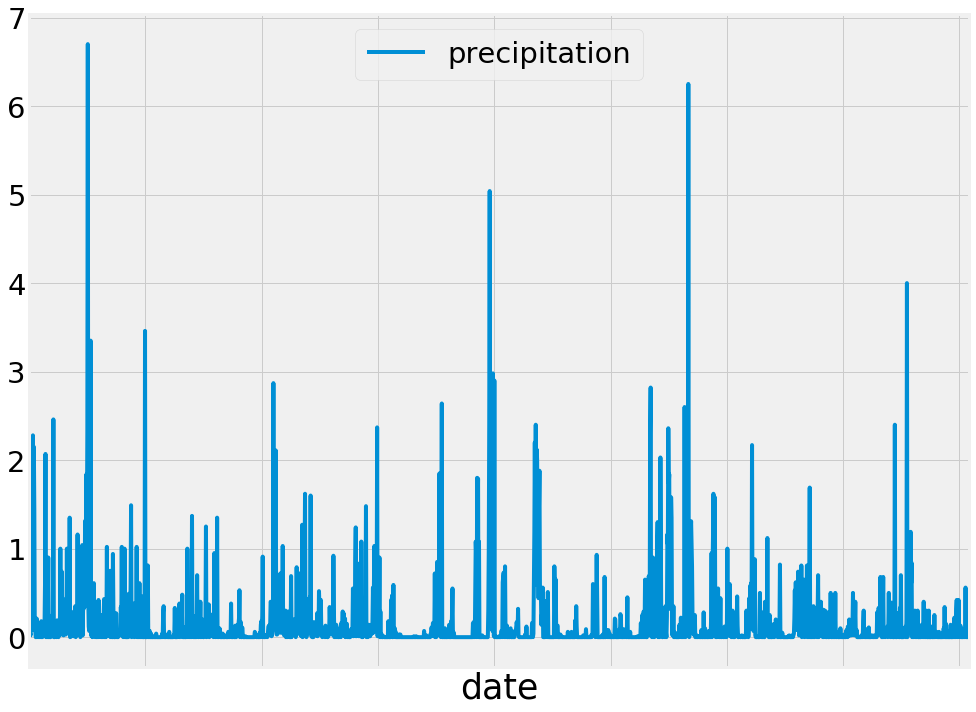

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
dataplot_data.plot(rot=90,figsize=(15,12))
plt.rcParams.update({'font.size': 29})
plt.legend(["precipitation"], loc='upper center')       
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.tight_layout
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
statistics = dataplot_data['prcp'].describe()
statistics_data=pd.DataFrame(statistics)
statistics_data.rename(columns = {'prcp':'precipitation'}, inplace = True) 
# statistics_data.style.set_properties(figsize=(16,12))
statistics_data

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
from IPython.display import HTML

styles = [
       dict(selector="th", props=[("font-size", "200%")]),
       dict(selector="td", props=[("font-size", "200%")])
]
   
html = (statistics_data.style.set_table_styles(styles))
html    

,precipitation
count,2021
mean,0.177279
std,0.46119
min,0
25%,0
50%,0.02
75%,0.13
max,6.7


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations in the dataset.".format(location_station))

There are 9 stations in the dataset.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Displaying in order -- 3 stations with the most rows
base_query = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).limit(3).all()
print(base_query)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709)]


In [21]:
# List the stations and the counts in descending order.base_query = session.query(Measurement.station, func.count(Measurement.date)).\
base_query = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

print(base_query)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

low_temp = session.query(Measurement.station,(func.min(Measurement.tobs))).all()
high_temp = session.query(Measurement.station,(func.max(Measurement.tobs))).all()

print(f'Station and lowest temperature recorded: {low_temp}')
print(f'Station and highest temperature recorded: {high_temp}')

Station and lowest temperature recorded: [('USC00511918', 53.0)]
Station and highest temperature recorded: [('USC00519397', 87.0)]


In [23]:
base_query = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).limit(1).all()[0][0]
print(f'Most active station is {base_query}')

Most active station is USC00519281


In [24]:
avg_temp=  session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==base_query).all()[0][0]
print(f'The average temperature at {base_query} is {avg_temp}')

The average temperature at USC00519281 is 71.66378066378067


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date_string = session.query(func.max(Measurement.date)).group_by(Measurement.station).\
       order_by(func.max(Measurement.date).desc()).limit(1).all()[0][0]

end_date = dt.datetime.strptime(date_string, '%Y-%m-%d').date()

start_date = end_date - dt.timedelta(days=365)

print(end_date)
print(start_date)

2017-08-23
2016-08-23


In [26]:
tobs = session.query(Measurement.tobs).filter(Measurement.date >= start_date).\
   filter(Measurement.station==base_query).all()

tobs_data=pd.DataFrame(tobs)
tobs_data.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


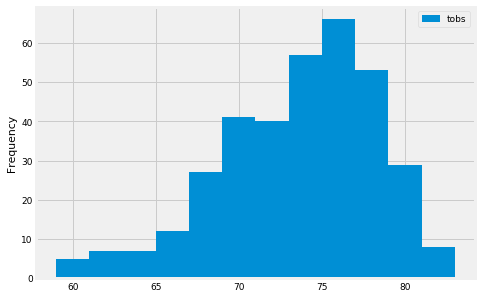

In [28]:
tobs_data.plot.hist(bins=12, figsize=(7,5))
plt.legend(loc='upper right') 
plt.rcParams.update({'font.size': 9})

plt.show()

![precipitation](Images/station-histogram.png)

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-01', '2016-08-04'))

[(72.0, 77.3076923076923, 82.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

from datetime import timedelta
year = timedelta(days = 365)

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
    end_date=end_date - year
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
    start_date=start_date - year

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#function usage example
print(calc_temps('2017-08-01', '2017-08-04'))

[(72.0, 77.3076923076923, 82.0)]


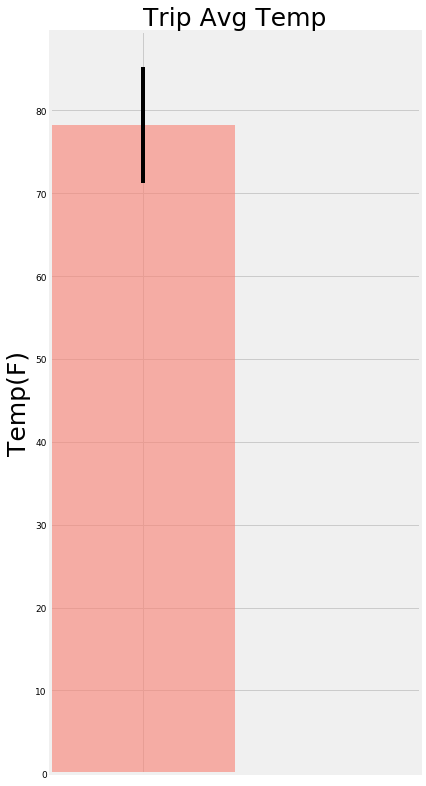

In [39]:
Avg = 78.28571428571429
Max = 81.0
Min = 74.0

fig, ax = plt.subplots(figsize=(6,11))
ax.bar(x=1, height=Avg, width=2, yerr=Max-Min, color='salmon', alpha=0.6)
ax.set_xlim(0,4)
ax.set_xticks([1])
ax.set_xticklabels('')
ax.set_ylabel('Temp(F)', fontsize= 25)
ax.set_title('Trip Avg Temp', fontsize=25)
plt.tight_layout()
plt.savefig("temperture_analysis.png", bbox_inches='tight')
plt.show()

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

date = dt.date(2017,8,1)
date2 = dt.date(2017,8,4)
t_date = dt.timedelta(days=365)
t_date2 = dt.timedelta(days=365)
start_date = date - t_date
end_date = date2 - t_date
print(f"Previous year's arrival date is {start_date} and return date is {end_date}")


sel = (Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))

stations_data = session.query(*sel).filter(Station.station == Measurement.station).\
filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(stations_data)   
   

Previous year's arrival date is 2016-08-01 and return date is 2016-08-04
[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 5.139999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 3.1900000000000004), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.3499999999999996), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.8600000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.55)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)



In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
